In [1]:
### Avni ### 

In [7]:
##Root Mean Squared Error. We will conside only non-zero ratings
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))
 

In [10]:
##Predit function to find user-user similarity and item-item similarity. User bias is removed by adjusting the
##mean user bias before predicting ratings
def predict(ratings, similarity, type='user',epsilon=1e20):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [13]:
##
##Find the top-k movie names based on the ordered ratings
##
def top_k_movies_byuser(prediction, mapper, user_idx, k=6):
    return [mapper[x] for x in np.argsort(prediction[user_idx,np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k-1:-1]]

In [14]:
##Predict the ratings using dot product of the latent features for users and items
def predictionSGD(P,Q):
    return np.dot(P.T,Q)

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances

In [16]:
trainRMSE = []
testRMSE = []

In [18]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)

Number of users = 943 | Number of movies = 1682


In [48]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.25)

In [49]:
#Create two user-item matrices, one for training and another for testing

train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[3]
        
        
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
        test_data_matrix[line[1]-1, line[2]-1] = line[3]        

In [51]:
# Load movie data
idx_to_movie = {}
with open('ml-100k/u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[1]

In [52]:
# Compute the cosine distance and 1-cosine distance yields cosine similarity.epsilon is used to handle the 
# divide by zero scenarios
epsilon=1e-9

user_similarity = (1-pairwise_distances(train_data_matrix, metric='cosine')) + epsilon

item_similarity = (1-pairwise_distances(train_data_matrix.T, metric='cosine')) + epsilon
 

In [53]:
user_idx = 16

In [54]:
pred = predict(train_data_matrix, user_similarity, type='user')
 

In [55]:
userBasedTrainRMSE = rmse(pred, train_data_matrix)
userBasedTestRMSE = rmse(pred, test_data_matrix)

In [56]:
trainRMSE.append(userBasedTrainRMSE)
testRMSE.append(userBasedTestRMSE)

In [57]:
print 'User-based CF MSE on train data: ' + str(userBasedTrainRMSE)
print 'User-based CF MSE on train data: ' + str(userBasedTestRMSE)+"\n"
print "Movies recommended to user " + str(user_idx) + " are:"
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print str(nearestMovies)  + "\n"

User-based CF MSE on train data: 2.89516426947
User-based CF MSE on train data: 2.96846942576

Movies recommended to user 16 are:
['Hoop Dreams (1994)', 'Turbo: A Power Rangers Movie (1997)', 'Toy Story (1995)', 'Princess Bride, The (1987)', 'Heat (1995)', 'Cable Guy, The (1996)']



In [58]:
pred = predict(train_data_matrix, item_similarity, type='item')

In [37]:
itemBasedTrainRMSE = rmse(pred, train_data_matrix)
itemBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(itemBasedTrainRMSE)
testRMSE.append(itemBasedTestRMSE)

In [38]:
print 'Item-based CF MSE on test data: ' + str(itemBasedTrainRMSE)
print 'Item-based CF MSE on test data: ' + str(itemBasedTestRMSE)+"\n"
print "Movies recommended to user " + str(user_idx) + " are:"
 
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print str(nearestMovies)  + "\n"

Item-based CF MSE on test data: 3.10052294452
Item-based CF MSE on test data: 3.15922145752

Movies recommended to user 16 are:
['Virtuosity (1995)', 'Invitation, The (Zaproszenie) (1986)', "Lover's Knot (1996)", 'Shallow Grave (1994)', 'Loaded (1994)', 'Getaway, The (1994)']



# SVD

In [39]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [40]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 30)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [41]:
modelBasedTrainRMSE = rmse(X_pred, train_data_matrix)
modelBasedTestRMSE = rmse(X_pred, test_data_matrix)
trainRMSE.append(modelBasedTrainRMSE)
testRMSE.append(modelBasedTestRMSE)

In [42]:
print 'Model-based CF MSE on train data: ' + str(modelBasedTrainRMSE)
print 'Model-based CF MSE on test data: ' + str(modelBasedTestRMSE) + "\n"
 

Model-based CF MSE on train data: 2.27825167047
Model-based CF MSE on test data: 2.78277944122



In [43]:
print "Movies recommended to user " + str(user_idx) + " are:"
nearestMovies = top_k_movies_byuser(X_pred, idx_to_movie, user_idx)
print str(nearestMovies) + "\n"

Movies recommended to user 16 are:
["My Best Friend's Wedding (1997)", 'Heat (1995)', 'Richard III (1995)', 'Truth About Cats & Dogs, The (1996)', 'Die Hard 2 (1990)', 'Gattaca (1997)']



In [59]:
# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Predicted Rating"] = X_pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
print ratings

   Actual Rating  Predicted Rating
0            4.0          1.990441
1            3.0          1.328916
2            4.0          3.863118
3            3.0          0.898068
4            1.0          0.619612


# RMSE in the model based CF is not any better than the memory based model. Another big issue with the matrix factorization approach is that it does not work well with missing data.MovieLens dataset that is considered in this script has no Nan/missing values and thus the SVD worked.

In [46]:
# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Predicted Rating"] = pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
print ratings

   Actual Rating  Predicted Rating
0            4.0          0.116125
1            4.0          0.117659
2            3.0          0.119754
3            3.0          0.133536
4            4.0          0.121288


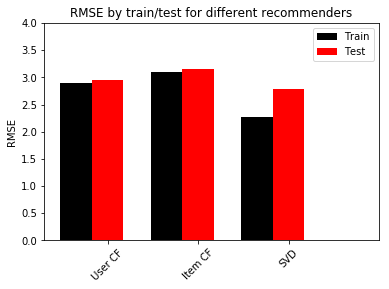

In [47]:
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
ax = fig.add_subplot(111)
 
## the data
N = 3
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars
 
## the bars
rects1 = ax.bar(ind, trainRMSE, width,color='black')
 
rects2 = ax.bar(ind+width, testRMSE, width, color='red')
 
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,4)
ax.set_ylabel('RMSE')
ax.set_title('RMSE by train/test for different recommenders')
xTickMarks = ['User CF','Item CF','SVD']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0]), ('Train', 'Test') )
plt.show()
